In [1]:
""" 
The algorithm is tested on the PDSystemEnv  gym task 
and developed with Tensorflow

Author: Daniel Salgado Rojo
"""

import tensorflow as tf
import numpy as np
import gym
import gym_pdsystem
from gym import wrappers
#import tflearn
import argparse
import pprint as pp

#from ddpg.replay_buffer import ReplayBuffer

from datetime import datetime

import random

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc


from matplotlib import animation, rc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import HTML


import pandas as pd
import time

from functools import partial

import os

#TO OMMIT WARNINGS
import warnings
warnings.filterwarnings('ignore')

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)   

/home/dsalgador/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# System's parmeters

In [2]:
# In order to change the parameters of the system, such as number of shops, trucks, etc, one must change
# the corresponding constants in the 'constants.py' file from the 'gym pd_system' package.

CASE = ct.CASE
STOCHASTIC = ct.STOCHASTIC 

###########################################################

TANK_MAX_LOADS = ct.TANK_MAX_LOADS
LEVEL_PERCENTAGES = ct.LEVEL_PERCENTAGES 
TRUCK_MAX_LOADS = ct.TRUCK_MAX_LOADS
GRAPH_WEIGHTS = ct.GRAPH_WEIGHTS 
DISCRETE = ct.DISCRETE

n = len(TANK_MAX_LOADS)
k = len(TRUCK_MAX_LOADS)

env = gym.make("PDSystemEnv-v0")
episode_length = 30
env._max_episode_steps = episode_length

###########################################################

print("System with k={} trucks and n={} shops. Episodes of {} days.".format(k,n,episode_length))

System with k=2 trucks and n=5 shops. Episodes of 30 days.


In [3]:
import utils_pg
from utils_pg import int_to_action
from utils_pg import action_to_int
from utils_pg import discount_rewards
from utils_pg import normalize_rewards

# Tensorflow graph (DNN) for MC Policy Gradient Algorithm

In [4]:
simulation_id = 72

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
models_dir = simulation_directory + '/NN-models'

if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(models_dir)
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

# Output headers to file
with open(rewards_file,'w') as f:
     np.savetxt(f, [["iteration", "discreward"]], fmt="%s", delimiter=',')

In [5]:
seed = 42
reset_graph(seed)

################################
# TensorBoard summary directories
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)   
################################

## DNN hyperparameters ################
learning_rate = 0.01 #0.01

hidden1_neurons = 100 #100
hidden2_neurons = 50 #50

# batch_normalization = True  
# batch_norm_momentum = 0.9
######################################



######################################
#### Training hyperparameters ########
######################################
# File names for the model

model_file = models_dir + "/pdenv_policy_net_pg.ckpt"#.format(learning_rate)
best_model_file = models_dir + "/pdenv_best_policy_net_pg.ckpt"#.format(learning_rate)
graph_file =  '{}.meta'.format(model_file)


# Simulation / Training parameters
n_games_per_update = 10
n_max_steps = episode_length
n_iterations = 500 #2*10**4
save_iterations = 100 # USEFUL WHEN USING EARLY STOPPING
discount_rate = 0.9

info_freq = 100 #100
round_time = 2
round_reward = 6
summary_freq = 20#int(info_freq/2), 10

# Early stopping
max_checks_without_progress = np.inf # 10,  one for each "info_freq" (in terms of iterations it would be
                                                            #max_checks_without_progress *  info_freq)
checks_without_progress = 0
best_reward = -np.infty


retrain = False
########################################



###### TENSORFLOW GRAPH #########
tf.set_random_seed(seed)
with tf.name_scope("dnn"):
        
            # 1. Parameters to determine the NN architecture

            n_inputs = env.observation_space.shape[1]
            n_hidden1 = hidden1_neurons; activation1 = tf.nn.sigmoid#tf.nn.elu
            n_hidden2 = hidden2_neurons; activation2 = tf.nn.sigmoid#tf.nn.elu
            n_outputs = env.action_space.shape[1]**env.action_space.shape[0]
            
            he_init = tf.contrib.layers.variance_scaling_initializer(seed = seed)

            X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
            
                    
            hidden1 = tf.layers.dense(X, n_hidden1, activation = activation1,
                                     kernel_initializer = he_init)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                                     kernel_initializer = he_init)
            logits = tf.layers.dense(hidden2, n_outputs, name = "logits"
                                     ,kernel_initializer = he_init)
            
            outputs = tf.nn.softmax(logits)
                   
            
with tf.name_scope("action"):
            # 3. Select a random action (where to go) based on the estimated probabilities
            action = tf.multinomial(tf.log(outputs), num_samples = 1)
            test_action = tf.argmax(outputs, axis = 1)
  
            y = tf.reshape(action, [1])
            
with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,logits = logits)
            loss = tf.reduce_mean(xentropy, name = "loss")
            
tf.summary.scalar('average_cross_entropy', loss)


with tf.name_scope("train"):
            # Optimization Op
            optimizer = tf.train.AdamOptimizer(learning_rate)
            
            grads_and_vars = optimizer.compute_gradients(xentropy)
            gradients = [grad for grad, variable in grads_and_vars]
            gradient_placeholders = []
            grads_and_vars_feed = []
            for grad, variable in grads_and_vars:
                gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
                gradient_placeholders.append(gradient_placeholder)
                grads_and_vars_feed.append((gradient_placeholder, variable))
            training_op = optimizer.apply_gradients(grads_and_vars_feed)
                        
                                       
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
        
saver = tf.train.Saver()
        

Instructions for updating:
Use the retry module or similar alternatives.


# PG Training

In [6]:
with tf.Session() as sess:
    
    #train_writer = tf.summary.FileWriter(logdir + '/pgtrain', sess.graph)
    if retrain:
        saver.restore(sess, model_file)
        
    summary2 = tf.Summary()
    if not retrain:
        init.run()
    time_start = time.time()

    for iteration in range(n_iterations+1):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)}) 
                #print(action_val)
                vect_action = int_to_action(action_val,env) #HERE WE CONVERT FROM INTEGER TO ACTION's Array
                #print(vect_action)
                obs, reward, done, info = env.step(vect_action)
                current_rewards.append(reward)
                current_gradients.append(gradients_val)                
                
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            
        
        all_disc_rewards =  [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
        all_disc_norm_rewards = normalize_rewards(all_disc_rewards)     

        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_disc_norm_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
         
       
        #tf.summary.scalar('avg_rewards', avg_rewards)
        #train_writer.add_summary(avg_rewards, iteration)

        # Summary and info printings     ###################################################################
        if iteration % info_freq == 0 or iteration % summary_freq == 0:  
            
            #avg_rewards =np.array([np.mean(np.array(all_rewards)) / n_games_per_update])
            avg_rewards =np.mean(np.array(all_disc_rewards)) / n_games_per_update
#             print(avg_rewards)
            #avg_rewards_list.append(avg_rewards)
            if iteration % summary_freq == 0:
                summary2.value.add(tag='average_reward_per_game', simple_value = avg_rewards)
                file_writer.add_summary(summary2, iteration)

                feed_dict[X] = obs.reshape(1, n_inputs)
                summary = sess.run(merged, feed_dict= feed_dict)

                file_writer.add_summary(summary, iteration)
                
                  # Disc rewards, etc ####
       
                with open(rewards_file,'ab') as f:
                            np.savetxt(f, [np.array([iteration,  avg_rewards])], fmt=("%d",'%.10f'), delimiter=',') 

            if iteration % info_freq == 0:
                time_end = time.time()
                print(". Average reward per game: ",  round(avg_rewards, round_reward), 
                      ", Elapsed time ", round( (time_end-time_start)/60., round_time), " minutes.") 
                
                
        ###########################################################################      
                
        if avg_rewards > best_reward:
                    saver.save(sess, best_model_file)
                    print("Saved Model with average discounted rewards per game ", avg_rewards)
                    best_reward = avg_rewards
                    checks_without_progress = 0
        else:
                    checks_without_progress += 1
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
        ####################################################################################################
        if iteration % save_iterations == 0:
                 saver.save(sess, model_file)
        
        sess.run(training_op, feed_dict=feed_dict)
    
    #saver.save(sess, model_file + "final")
    file_writer.flush()
    file_writer.close()
                 
    time_end = time.time()
    print("Simulation finished. Elapsed time ", round( (time_end-time_start)/60., round_time), " minutes.") 
        

Iteration: 0. Average reward per game:  -1.795496 , Elapsed time  0.0  minutes.
Saved Model with average discounted rewards per game  -1.7954960515164253
Iteration: 20Saved Model with average discounted rewards per game  -1.2335080910713567
Iteration: 40Saved Model with average discounted rewards per game  -0.6661102964944273
Iteration: 60Saved Model with average discounted rewards per game  -0.5636164829053075
Iteration: 80Saved Model with average discounted rewards per game  -0.4591970757968391
Iteration: 100. Average reward per game:  -0.423802 , Elapsed time  0.39  minutes.
Saved Model with average discounted rewards per game  -0.42380242822085956
Iteration: 120Saved Model with average discounted rewards per game  -0.27652615600244407
Iteration: 140Saved Model with average discounted rewards per game  -0.2125299747480967
Iteration: 200. Average reward per game:  -0.268235 , Elapsed time  0.77  minutes.
Iteration: 220Saved Model with average discounted rewards per game  -0.202998054

## Visualizations

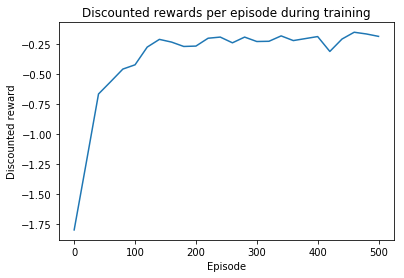

In [7]:
# Visualizing train simulation:

#episode =episodes
#simulation_id = 2
#step = 30

discrewards = pd.read_table(rewards_file, sep = ",")

indices = [i for i in range(0,n_iterations,1)]

plt.plot(discrewards['iteration'][indices],discrewards['discreward'][indices], label = "Discounted rewards")
plt.title("Discounted rewards per episode during training")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")

plt.show()
plt.close()

# PG Testing

In [14]:
seed = 45 # this seed determines the initialization of the system when calling env.reset() ,etc
np.random.seed(seed)

frames = []
n_episodes = 1

system = PDSystemEnv()
#model_file = "pdenv_policy_net_pg.ckpt"
test_model_file = best_model_file

with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 


with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess, test_model_file)
        for episode in range(n_episodes):
            state = env.reset()
            for step in range(episode_length):
                system.state = state
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode)*(episode_length)+step]+state.tolist())], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',') 
                img = system.visualize()
                frames.append(img)

                action_val = test_action.eval(feed_dict={X: state.reshape(1, n_inputs)})
                #print(action_val)
                vect_action = int_to_action(action_val,env) #HERE WE CONVERT FROM INTEGER TO ACTION's Array
                #print(vect_action)
                state, reward, done, info = env.step(vect_action)
               
        env.close()
    

INFO:tensorflow:Restoring parameters from ./simulations/simulation72/NN-models/pdenv_best_policy_net_pg.ckpt


## Giff animation

In [9]:
test_anim = ut.create_system_animation(frames, n_episodes * episode_length)
plt.close()

HTML(test_anim.to_html5_video())

## Visualization with matplotlib

In [10]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    #tanks = test_toy_system.tanks
    tanks_max_load = system.tank_max_loads
    level_percentages = system.load_level_percentages

    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, level_percentages[i-1]):
            plt.axhline(y= lvl * tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = level_percentages[i-1]           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length*n_episodes+1,5*n_episodes
                        ))


    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + '{}'.format(simulation_id) + '.pdf')
    plt.show()
    plt.close()

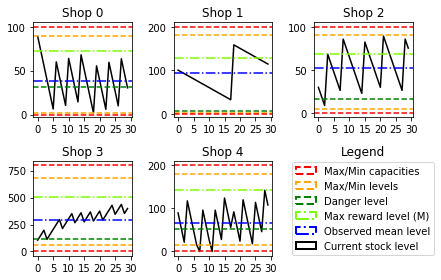

In [11]:
visualize_simulation(states_file,
                        system,
                        simulation_id,
                        simulation_directory)   

## Performance metrics

In [12]:
# Total discounted rewards Level rewards Transport rewards
# -0.9461630048478756 -1.4940858493344584 0.0
# Average trucks sent:  43.9
# Average 1st type Trucks sent to each shop: [6.6 1.1 4.  4.7 6.5 7.1]
# Average 2nd type Trucks sent to each shop: [ 0.5  0.1  1.1 15.   4.3  9. ]
# Average number of trucks not deliverying: 2.2
# Average level counts for shop 0: [ 0.2  0.1  9.2 20.2  0.3]
# Average level counts for shop 1: [ 0.  0.  0. 30.  0.]
# Average level counts for shop 2: [ 0.9  0.3  2.4 26.2  0.2]
# Average level counts for shop 3: [ 0.1  0.8  2.7 26.2  0.2]
# Average level counts for shop 4: [ 0.1  0.  10.5 19.3  0.1]
# Average total level counts: [  1.3   1.2  24.8 121.9   0.8]

In [20]:
seed = 45 # this seed determines the initialization of the system when calling env.reset() ,etc
np.random.seed(seed)

frames = []
n_episodes = 1

system = PDSystemEnv()
#model_file = "pdenv_policy_net_pg.ckpt"
test_model_file = best_model_file

with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

####
test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []
test_number_of_first_trucks_sent_list = []
test_number_of_second_trucks_sent_list = []
test_number_of_trucks_not_deliverying_list = []
####

with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess, test_model_file)
        for episode in range(n_episodes):
            #####
            discounted_reward = 0 
            transport_rewards = 0
            level_rewards = 0
            number_of_trucks_sent = 0
            number_of_first_trucks_sent = np.zeros(n+1, dtype = np.int64)
            number_of_second_trucks_sent = np.zeros(n+1, dtype = np.int64)
            number_of_trucks_not_deliverying = 0                   
            #####         
         
            state = env.reset()
            for step in range(episode_length):
                system.state = state
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode)*(episode_length)+step]+state.tolist())], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',') 
                img = system.visualize()
                frames.append(img)

                action_val = test_action.eval(feed_dict={X: state.reshape(1, n_inputs)})
                #print(action_val)
                vect_action = int_to_action(action_val,env) #HERE WE CONVERT FROM INTEGER TO ACTION's Array
                #print(vect_action)
                state, reward, done, info = env.step(vect_action)
            
                trucks_not_del = info["trucks_not_deliverying"]
                level_reward = info["level_rewards"]
                transport_reward = info["transport_rewards"]
                ### STORE STEP INFO
                discounted_reward = discounted_reward + (discount_rate**(step)) * reward
                transport_rewards = transport_rewards+transport_reward
                level_rewards = level_rewards + level_reward
                
                number_of_trucks_sent = number_of_trucks_sent + np.sum(vect_action == 5)
                index1 = vect_action[0]
                number_of_first_trucks_sent[index1] = number_of_first_trucks_sent[index1] + 1
                index2 = vect_action[1]
                number_of_second_trucks_sent[index2] = number_of_second_trucks_sent[index2] + 1
                number_of_trucks_not_deliverying =  number_of_trucks_not_deliverying + trucks_not_del
                
            test_rewards_list.append(discounted_reward);
            test_transport_rewards_list.append(transport_rewards);
            test_level_rewards_list.append(level_rewards);
            test_trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);
            test_number_of_first_trucks_sent_list.append(number_of_first_trucks_sent);
            test_number_of_second_trucks_sent_list.append(number_of_second_trucks_sent);
            test_number_of_trucks_not_deliverying_list.append(number_of_trucks_not_deliverying);                   
                
               
        env.close()
 
print("Total discounted rewards","Level rewards", "Transport rewards")
print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)
    
#     if n_episodes == 1:
print("Average 1st type Trucks sent to each shop:", sum(test_number_of_first_trucks_sent_list)/n_episodes )
print("Average 2nd type Trucks sent to each shop:", sum(test_number_of_second_trucks_sent_list)/n_episodes )
print("Average number of trucks not deliverying:", sum(test_number_of_trucks_not_deliverying_list)/n_episodes )

INFO:tensorflow:Restoring parameters from ./simulations/simulation72/NN-models/pdenv_best_policy_net_pg.ckpt
Total discounted rewards Level rewards Transport rewards
-1.2818449238781504 -1.9889848809813686 0.03676013522999999
Average trucks sent:  44.0
Average 1st type Trucks sent to each shop: [ 6.  0.  7.  0.  1. 16.]
Average 2nd type Trucks sent to each shop: [ 0.  1.  0. 22.  7.  0.]
Average number of trucks not deliverying: 2.0
